# Exploratory Data Analysis of Show Reviews

In this notebook I'm going to explore the reviews' dataset.

## Imports

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [ ]:
from shows_analysis.code.sentiment_analysis.huggingface_pipeilne import Tokenizer

In [2]:
SEED = 42

## Functions

In [89]:
def plot_per_type(
    dataframe: pd.DataFrame,
    column: str,
    title: str,
    bins: int = 10,
    figsize: Tuple[int] = (8, 4),
):
    f, ax = plt.subplots(1, 2, figsize=figsize)

    dataframe[dataframe["type"] == "movie"][column].plot.hist(
        ax=ax[0], edgecolor="black", color="red", bins=bins
    )
    ax[0].set_title("Type = movie")

    dataframe[dataframe["type"] == "series"][column].plot.hist(
        ax=ax[1], edgecolor="black", color="green", bins=bins
    )
    ax[1].set_title("Type = series")

    f.tight_layout()
    f.suptitle(title, y=1.1)
    plt.show()

In [4]:
def plot_dt_per_type(
    dataframe: pd.DataFrame,
    column: str,
    title: str,
    bins: int = 24,
    figsize: Tuple[int] = (14, 4),
):
    f, ax = plt.subplots(1, 2, figsize=figsize)

    dataframe[dataframe["type"] == "movie"][column].hist(
        ax=ax[0], edgecolor="black", color="red", bins=np.arange(bins + 1) - 0.5
    )
    ax[0].set_title("Type = movie")
    ax[0].set_xticks(range(bins), minor=False)
    ax[0].grid(visible=None)

    dataframe[dataframe["type"] == "series"][column].hist(
        ax=ax[1], edgecolor="black", color="green", bins=np.arange(bins + 1) - 0.5
    )
    ax[1].set_title("Type = series")
    ax[1].set_xticks(range(bins), minor=False)
    ax[1].grid(visible=None)

    f.suptitle(title, y=1.0)

    plt.show()

## Paths

In [5]:
relative_path = os.path.join("../../../", "data")
cleaned_reviews_path = os.path.join(relative_path, "2_cleaned_reviews")

## Data

### Loading data

In [27]:
reviews = pd.read_parquet(os.path.join(cleaned_reviews_path, "reviews.parquet"))
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206737 entries, 0 to 206736
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   show_id       206737 non-null  int64         
 1   user_id       206737 non-null  int64         
 2   type          206737 non-null  category      
 3   datetime      206737 non-null  datetime64[ns]
 4   sentiment     206737 non-null  category      
 5   subtitle      173836 non-null  object        
 6   review        206737 non-null  object        
 7   review_score  206737 non-null  int64         
 8   score         129344 non-null  float64       
dtypes: category(2), datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 11.4+ MB


### Dataset overview

In [7]:
reviews.sample(n=10, random_state=SEED)

,show_id,user_id,type,datetime,sentiment,subtitle,review,review_score,score
196236,257386,28525,series,2010-08-27 11:23:00,positive,Вечный город.,К истории Древнего мира у меня отношение особо...,40,NaN
128582,688832,44953,movie,2015-02-20 23:19:00,negative,50 оттенков разочарования,"Говорю сразу, книги читала все, да и по нескол...",5,3.0
159673,349,33910,movie,2018-04-15 21:04:00,positive,"Господи, спасибо, что не пронесло мимо","Есть два типа фильмов, мой друг. Одни ты прост...",4,NaN
109244,686898,44065,movie,2019-11-09 11:58:00,neutral,Что же стало с клоуном?,"Итак, в первую очередь хотелось бы отметить то...",2,6.5
92610,61455,66782,movie,2017-11-27 18:52:00,positive,Они отказываются подчиняться,"Автора этого замечательного фильма, Джосса Уэд...",5,NaN
43727,491724,44563,movie,2012-01-28 23:18:00,positive,Жестокая правда,"Финчер снова нас поразил, он всегда нас поража...",7,10.0
50195,102130,67145,movie,2009-08-17 11:56:00,positive,"Преодолеть 2 года жизни, что встретиться","Слышал о фильме много, и в основном положитель...",11,10.0
43651,491724,66283,movie,2012-02-19 15:33:00,negative,"Мужчины, которые ненавидели женщин.",Я попробовала рассматривать этот фильм с двух ...,3,6.0
48775,7226,7905,movie,2014-02-20 03:44:00,positive,None,"«Догвилль» - это один из тех редких фильмов, п...",3,10.0
75262,458,33255,movie,2013-06-22 21:14:00,positive,Тайна закрытой двери,Я имела счастье смотреть этот мультфильм в кин...,6,10.0


## EDA

### Descriptive statistics

In [8]:
reviews.shape[0]

206737

Overall, users left `206 737` reviews.  

In [9]:
reviews[["show_id", "user_id"]].nunique()

show_id     1862
user_id    69172
dtype: int64

The number of unique users that left reviews is `69172`. While the number of unique shows (movies/series) is `1862`.

`171 094` reviews were left for movies, which is approximately `83%`.

In [10]:
reviews["type"].value_counts()

movie     171094
series     35643
Name: type, dtype: int64

### Users

Let's look at the activity of the users

In [11]:
number_of_reviews_per_user_per_type = (
    reviews.groupby("type")
    .agg({"user_id": "value_counts"})
    .rename(columns={"user_id": "reviews_per_user"})
    .reset_index()
)

In [12]:
number_of_reviews_per_user_per_type.groupby("type")["reviews_per_user"].describe(
    percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999]
)

,count,mean,std,min,1%,10%,25%,50%,75%,90%,95%,99%,99.9%,max
type,,,,,,,,,,,,,,
movie,58114.0,2.944110,8.693822,1.0,1.0,1.0,1.0,1.0,2.0,5.0,9.0,30.0,127.887,494.0
series,20465.0,1.741656,3.254028,1.0,1.0,1.0,1.0,1.0,2.0,3.0,4.0,12.0,38.536,150.0


As we can see, on average, users leave 3 reviews, but the median value is equal to 1 review.  
It means that we have a lot of outliers - people, who leave enormous amounts of reviews.

In [13]:
number_of_reviews_per_user_per_type_cut = number_of_reviews_per_user_per_type[
    number_of_reviews_per_user_per_type["reviews_per_user"] <= 9
]

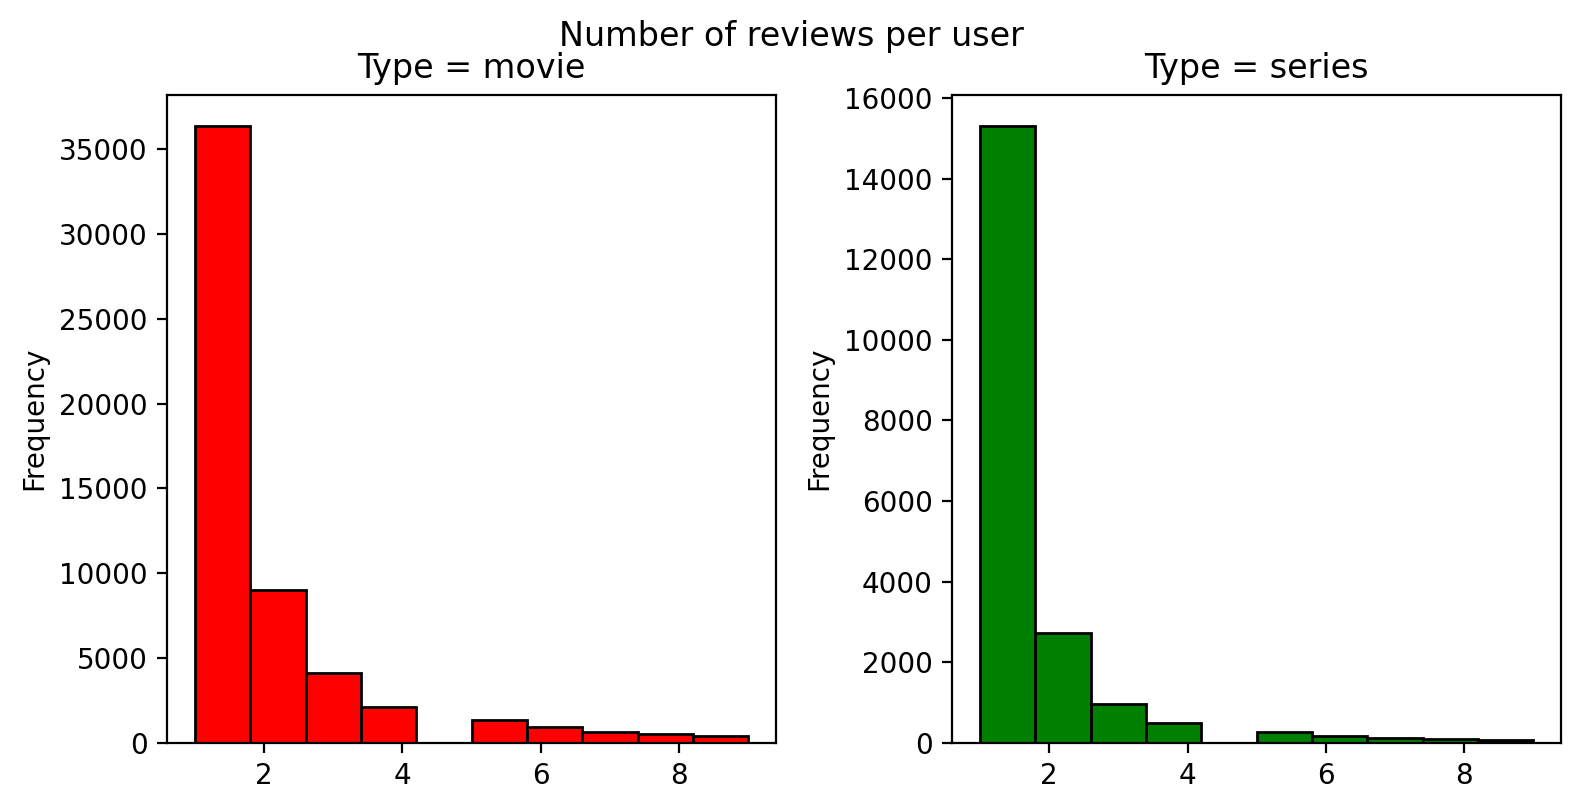

In [14]:
plot_per_type(
    dataframe=number_of_reviews_per_user_per_type_cut,
    column="reviews_per_user",
    title="Number of reviews per user",
)

We can see that most of the users leave from 1 to 4 reviews and the distribution of reviews does not differ for movies and series.

### Reviews

Let's analyze the popularity of the shows.

In [15]:
number_of_reviews_per_user_per_type = (
    reviews.groupby("type")
    .agg({"show_id": "value_counts"})
    .rename(columns={"show_id": "reviews_per_show"})
    .reset_index()
)

In [16]:
number_of_reviews_per_user_per_type.groupby("type")["reviews_per_show"].describe(
    percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999]
)

,count,mean,std,min,1%,10%,25%,50%,75%,90%,95%,99%,99.9%,max
type,,,,,,,,,,,,,,
movie,947.0,180.669483,210.445283,1.0,1.0,7.0,35.0,123.0,253.0,400.0,578.4,945.56,1771.462,2200.0
series,915.0,38.954098,69.856888,1.0,1.0,3.0,6.0,16.0,43.0,87.6,137.6,378.40,658.332,715.0


On average, people leave approximately 181 reviews per movie and 39 reviews per series.

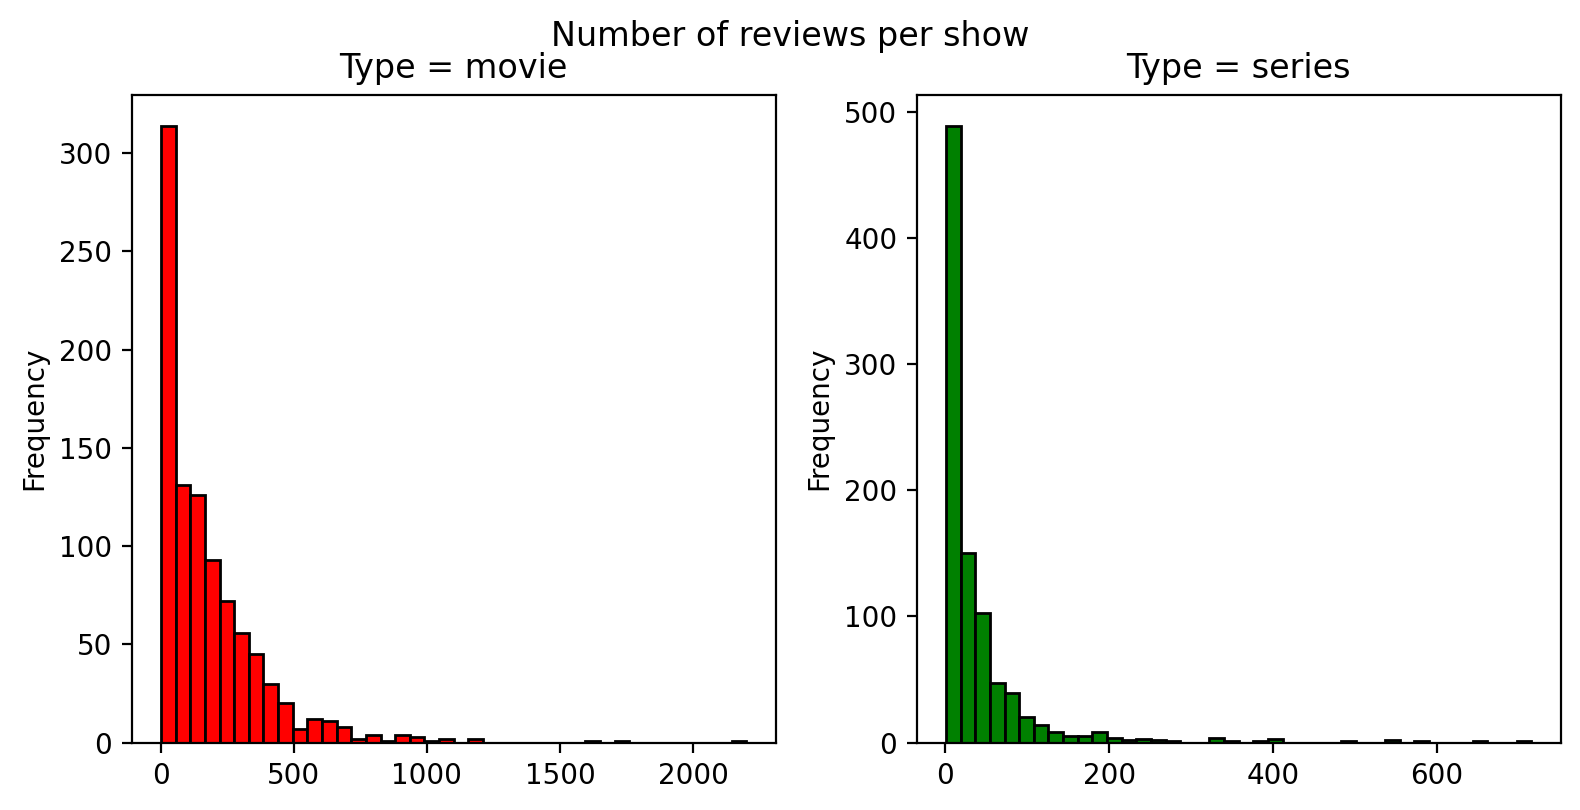

In [17]:
plot_per_type(
    dataframe=number_of_reviews_per_user_per_type,
    column="reviews_per_show",
    title="Number of reviews per show",
    bins=40,
)

Here we see expected pattern - there are few movies, which have a lot of reviews.

### Date and time of review

In [18]:
reviews["hour"] = reviews["datetime"].dt.hour
reviews["weekday"] = reviews["datetime"].dt.weekday
reviews["month"] = reviews["datetime"].dt.month - 1

#### Hour distribution

Let's look at hour distribution

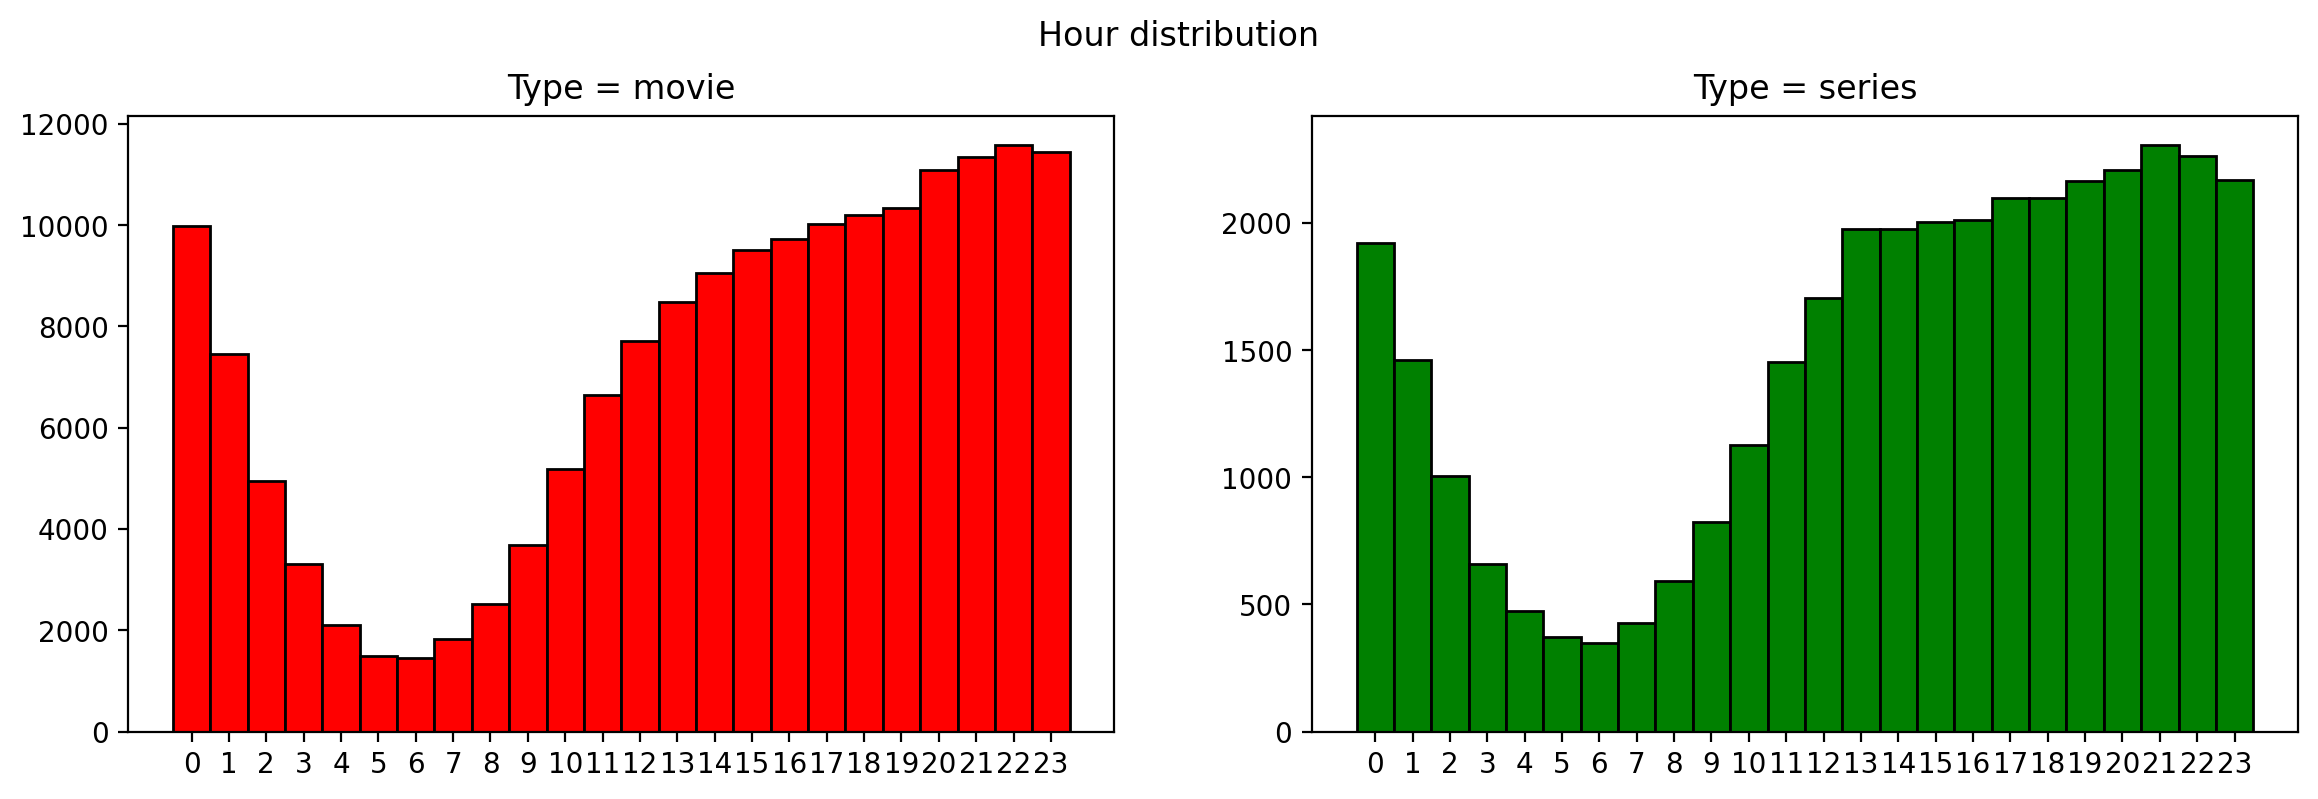

In [19]:
plot_dt_per_type(
    dataframe=reviews,
    column="hour",
    title="Hour distribution",
)

People tend to publish reviews closer to the night with absolute maximum around 20-23 o'clock and absolute minimum around 4-7 o'clock.  
Although, I'm not sure whether timezone was taken into account (all data is +3 UTC) or these dates and times are distributed along 11 time zones.  

Let's think that we have dates and times, which were actual for the people when they left their reviews.

##### Weekday distribution

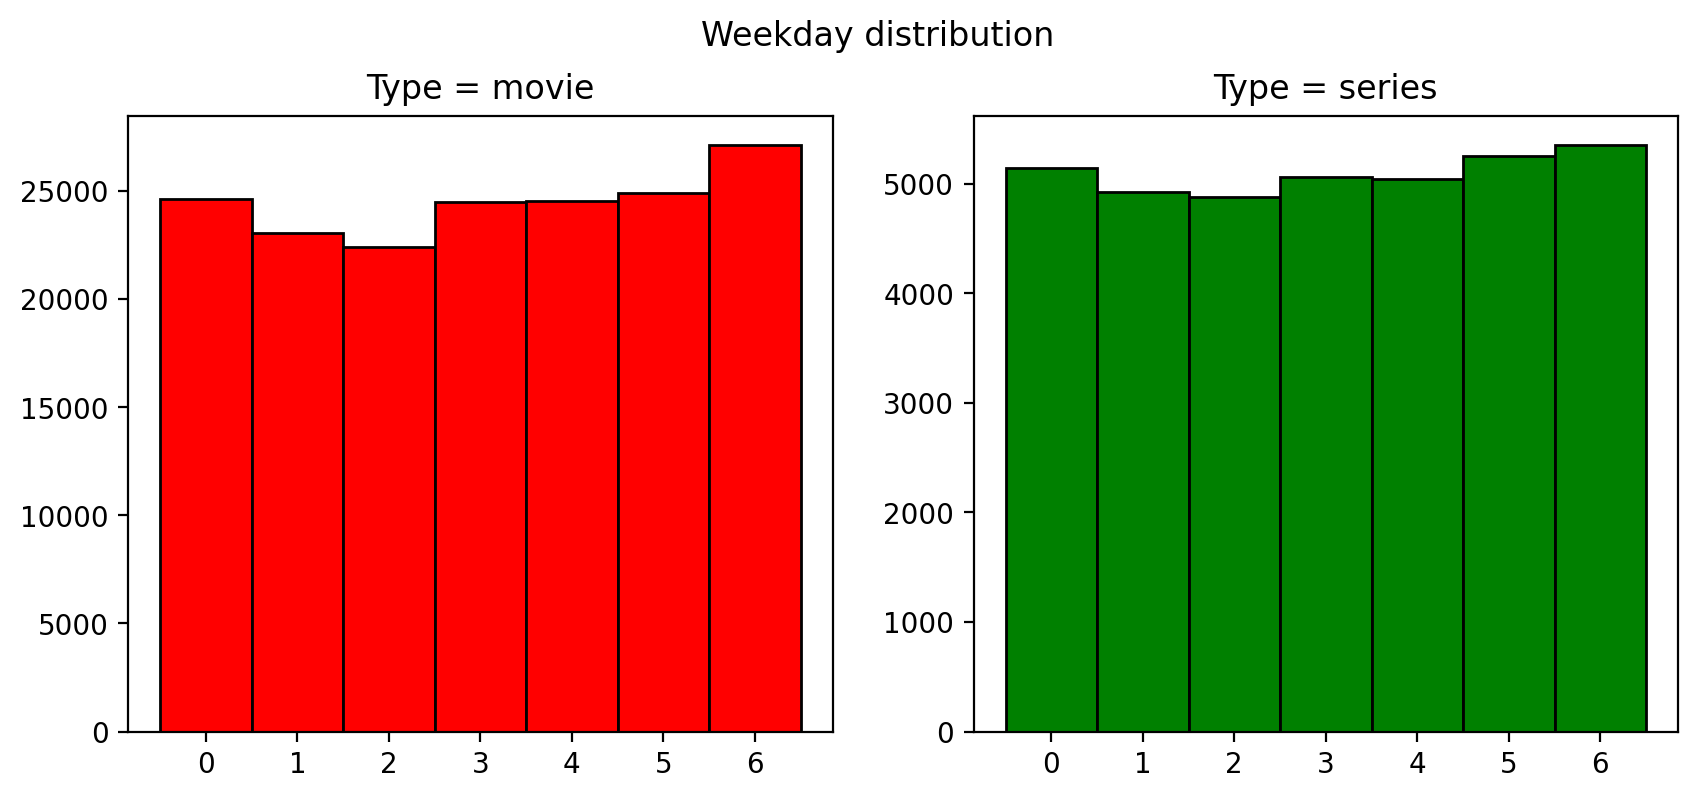

In [20]:
plot_dt_per_type(
    dataframe=reviews,
    column="weekday",
    title="Weekday distribution",
    bins=7,
    figsize=(10, 4),
)

People tend to publish more reviews on Sundays, but between Mondays, Thursdays, Fridays and Saturdays the difference is not that significant

##### Month distribution

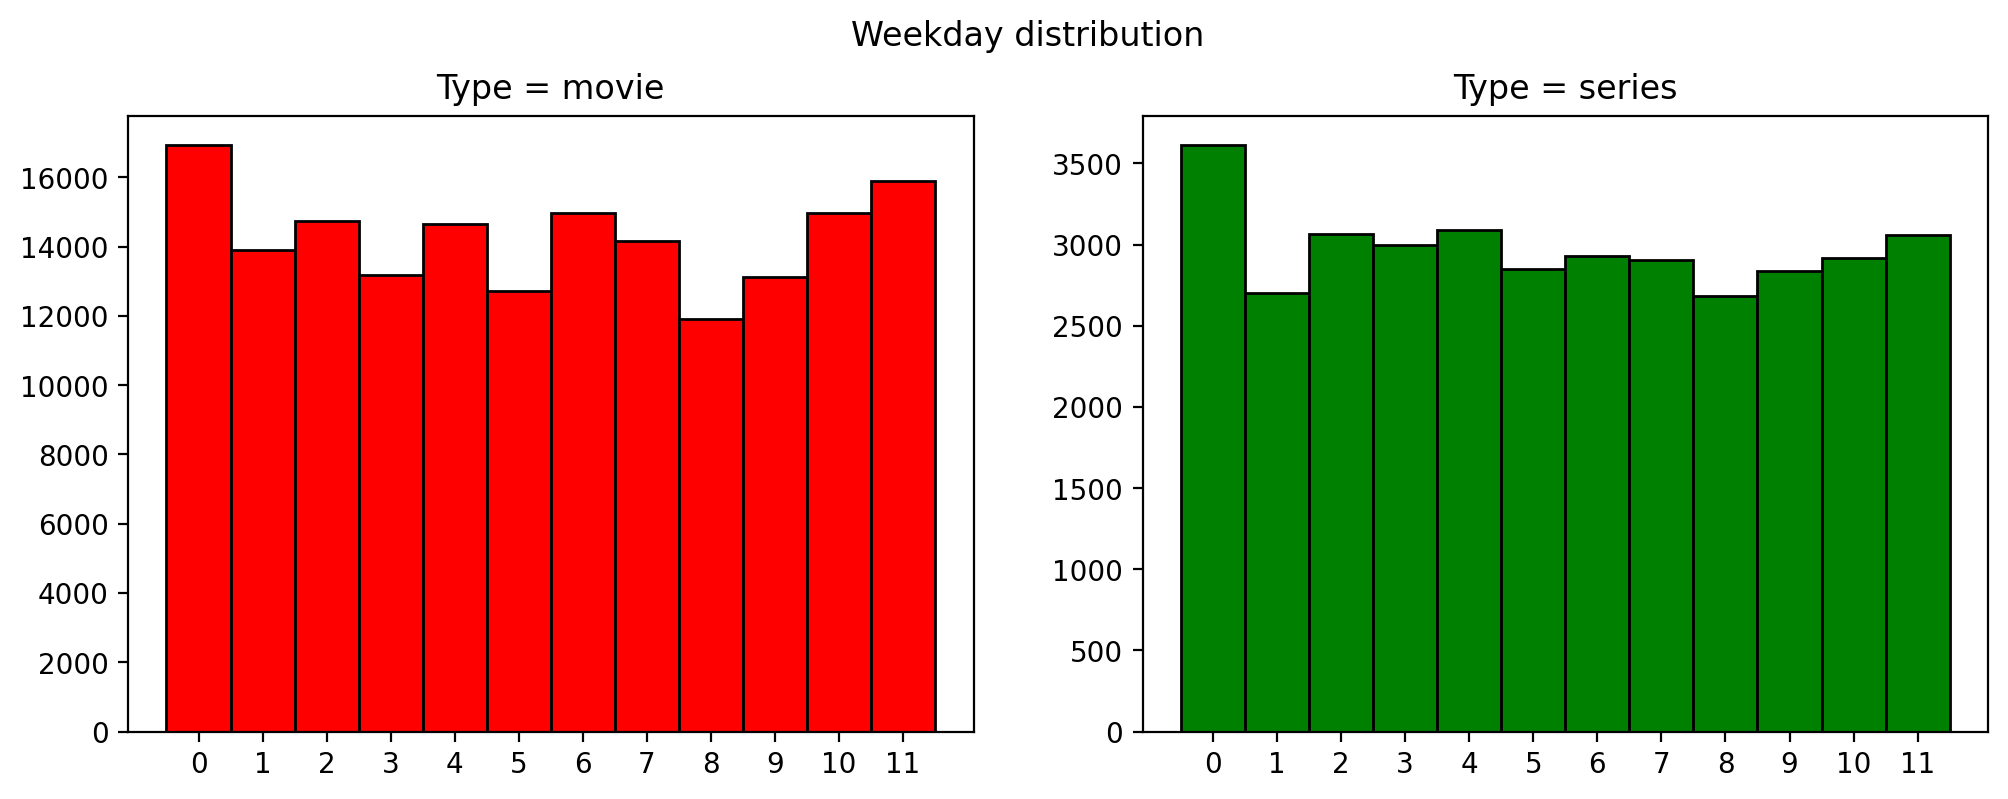

In [21]:
plot_dt_per_type(
    dataframe=reviews,
    column="month",
    title="Weekday distribution",
    bins=12,
    figsize=(12, 4),
)

People tend to publish more reviews on winter months (especially on January). It can be caused by the number of holidays in Russia in January and, also, generally correlated with cold weather.

### Sentiment

Let's look at sentiment by show type.

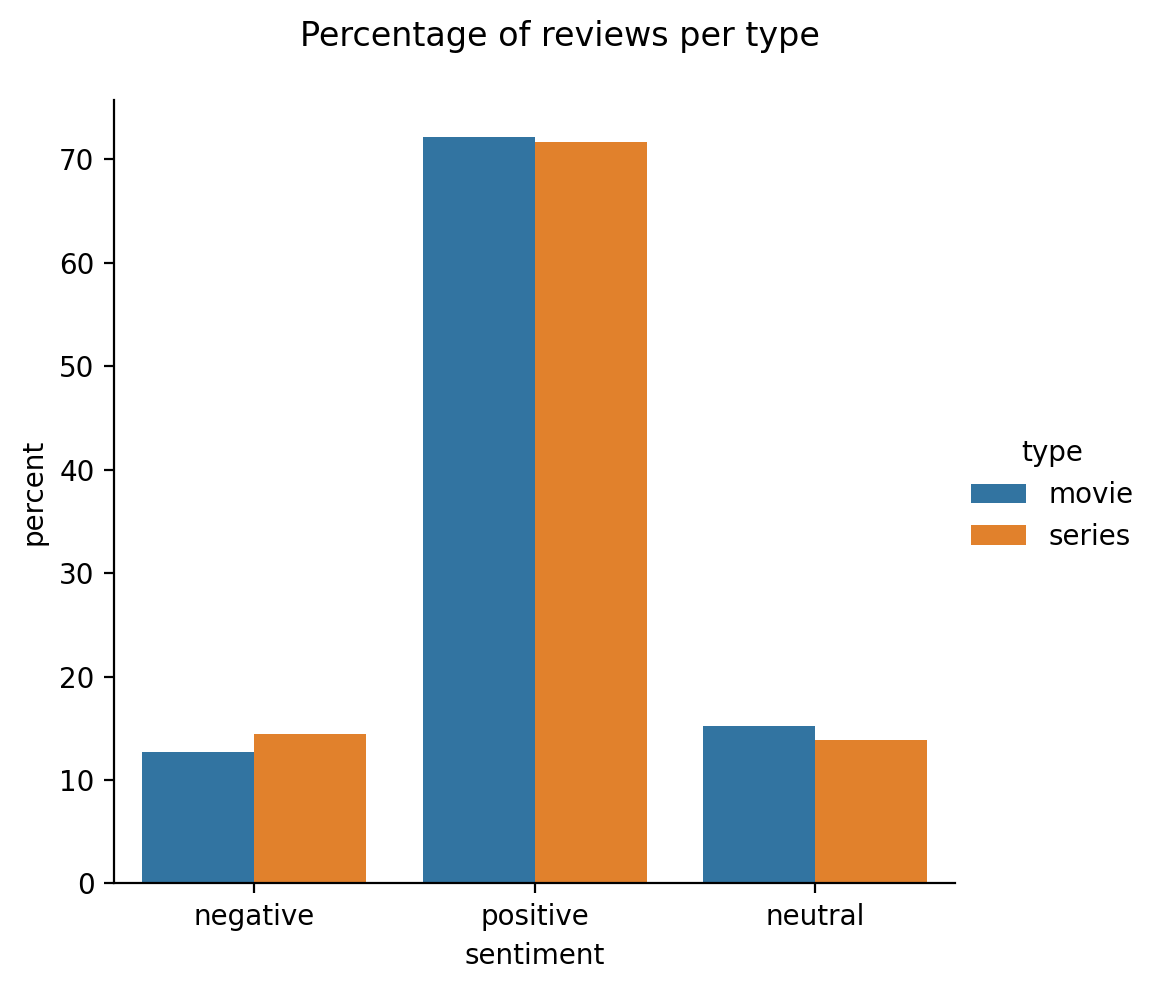

In [22]:
sentiment_by_type = (
    reviews.groupby(["type"])["sentiment"]
    .value_counts(normalize=True)
    .mul(100)
    .rename("percent")
    .reset_index()
    .rename(columns={"level_1": "sentiment"})
    .round(2)
)


plot = sns.catplot(
    data=sentiment_by_type, x="sentiment", y="percent", hue="type", kind="bar"
)
plot.figure.subplots_adjust(top=0.9)
plot.fig.suptitle("Percentage of reviews per type")

In [23]:
sentiment_by_type

,type,sentiment,percent
0,movie,positive,72.11
1,movie,neutral,15.23
2,movie,negative,12.66
3,series,positive,71.66
4,series,negative,14.47
5,series,neutral,13.88


We can see that the proportions roughly the same for movies and series.  
People tend to leave positive reviews (around 70%). The shares of neutral and negative reviews are almost the same (around 12%-15%).

### Subtitle

In [24]:
reviews["subtitle"].isna().sum() * 100 / reviews.shape[0]

15.91442267228411

84% of reviews have subtitle.

In [25]:
reviews["subtitle"]

0                              Достойное зрелище!
1                              «Ломать, колотить»
2                                   Лок`Тар огар!
3                       Маляры из студии Близзард
4                            Непонятый новый мир!
                           ...                   
206732                              Но я — зомби…
206733               Продолжая тему «умных зомби»
206734                             Зомби от Apple
206735                             Зомби-детектив
206736    Veronica Mars meets the Vampire Diaries
Name: subtitle, Length: 206737, dtype: object

This field is not very interesting, so we are not going to analyze it further.

### Review

#### Preparation

In [40]:
reviews["review"] = reviews["review"].str.replace("<p>", " ")

In [43]:
tokenizer = Tokenizer(max_length=None)

In [49]:
reviews["number_of_tokens"] = reviews["review"].apply(
    lambda review: tokenizer.tokenize(review)["input_ids"].shape[1]
)

#### Analysis

In [87]:
reviews.groupby("type")["number_of_tokens"].describe(
    percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999]
)

,count,mean,std,min,1%,10%,25%,50%,75%,90%,95%,99%,99.9%,max
type,,,,,,,,,,,,,,
movie,171094.0,506.498521,291.683525,2.0,75.0,203.0,295.0,439.0,651.0,918.0,1114.0,1388.0,1521.000,4770.0
series,35643.0,505.012036,298.736826,2.0,73.0,197.0,287.0,432.0,649.0,936.0,1148.0,1395.0,1524.716,2234.0


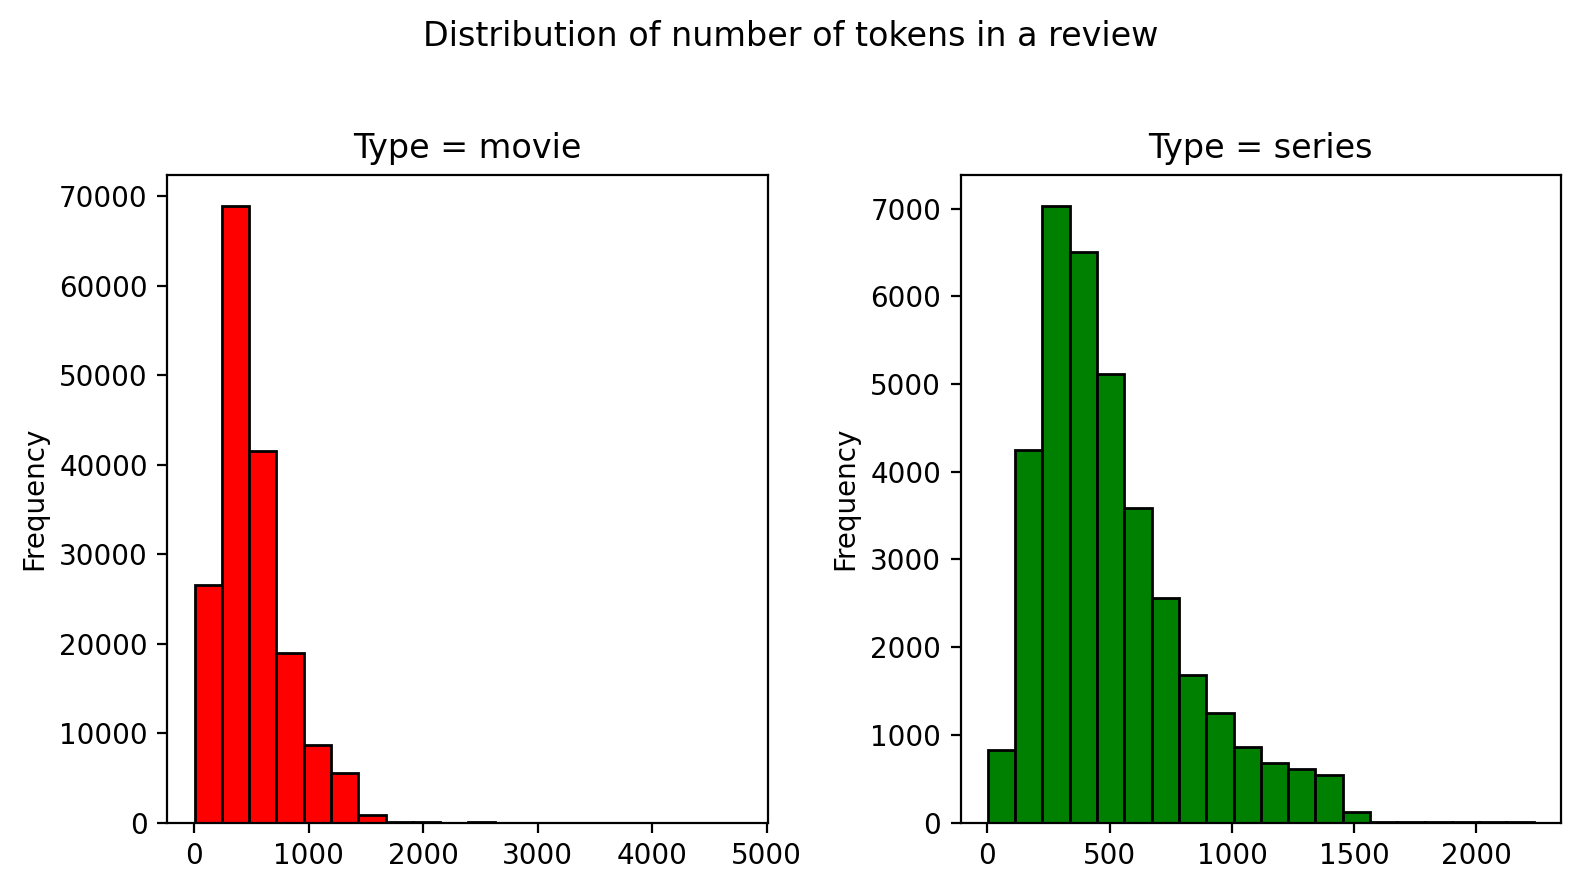

In [91]:
plot_per_type(
    dataframe=reviews,
    column="number_of_tokens",
    title="Distribution of number of tokens in a review",
    bins=20,
)

As we can see, some reviews are longer than 512 tokens, which is not good, because usually BERT-like architectures have a max length limit of tokens equal to 512. 

Basically, we have two options in the future:

 - Cut the longer texts off and only use the first/last 512 tokens. The original BERT implementation (and probably the others as well) truncates longer sequences automatically. For most cases, this option is sufficient.
 - Split reviews in multiple subtexts, classifier each of them and combine the results back together (choose the class which was predicted for most of the subtexts for example). This option is obviously more expensive.

### Review score

On this online platform users are allowed to leave feedback for others reviews. 
They can either up-vote or down-vote a review.

In [83]:
reviews["review_score"].describe(
    percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999]
)

count    206737.000000
mean          3.836236
std          67.719842
min       -9332.000000
1%         -149.000000
10%         -11.000000
25%          -1.000000
50%           4.000000
75%          12.000000
90%          25.000000
95%          41.000000
99%         112.000000
99.9%       428.000000
max        4921.000000
Name: review_score, dtype: float64

In [61]:
reviews.groupby("type")["review_score"].describe(
    percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999]
)

,count,mean,std,min,1%,10%,25%,50%,75%,90%,95%,99%,99.9%,max
type,,,,,,,,,,,,,,
movie,171094.0,3.332431,62.723841,-9332.0,-137.07,-11.0,-1.0,3.0,11.0,22.0,35.0,102.0,401.907,4921.0
series,35643.0,6.254608,87.791749,-4820.0,-222.00,-15.0,0.0,7.0,21.0,42.0,61.0,150.0,506.148,1960.0


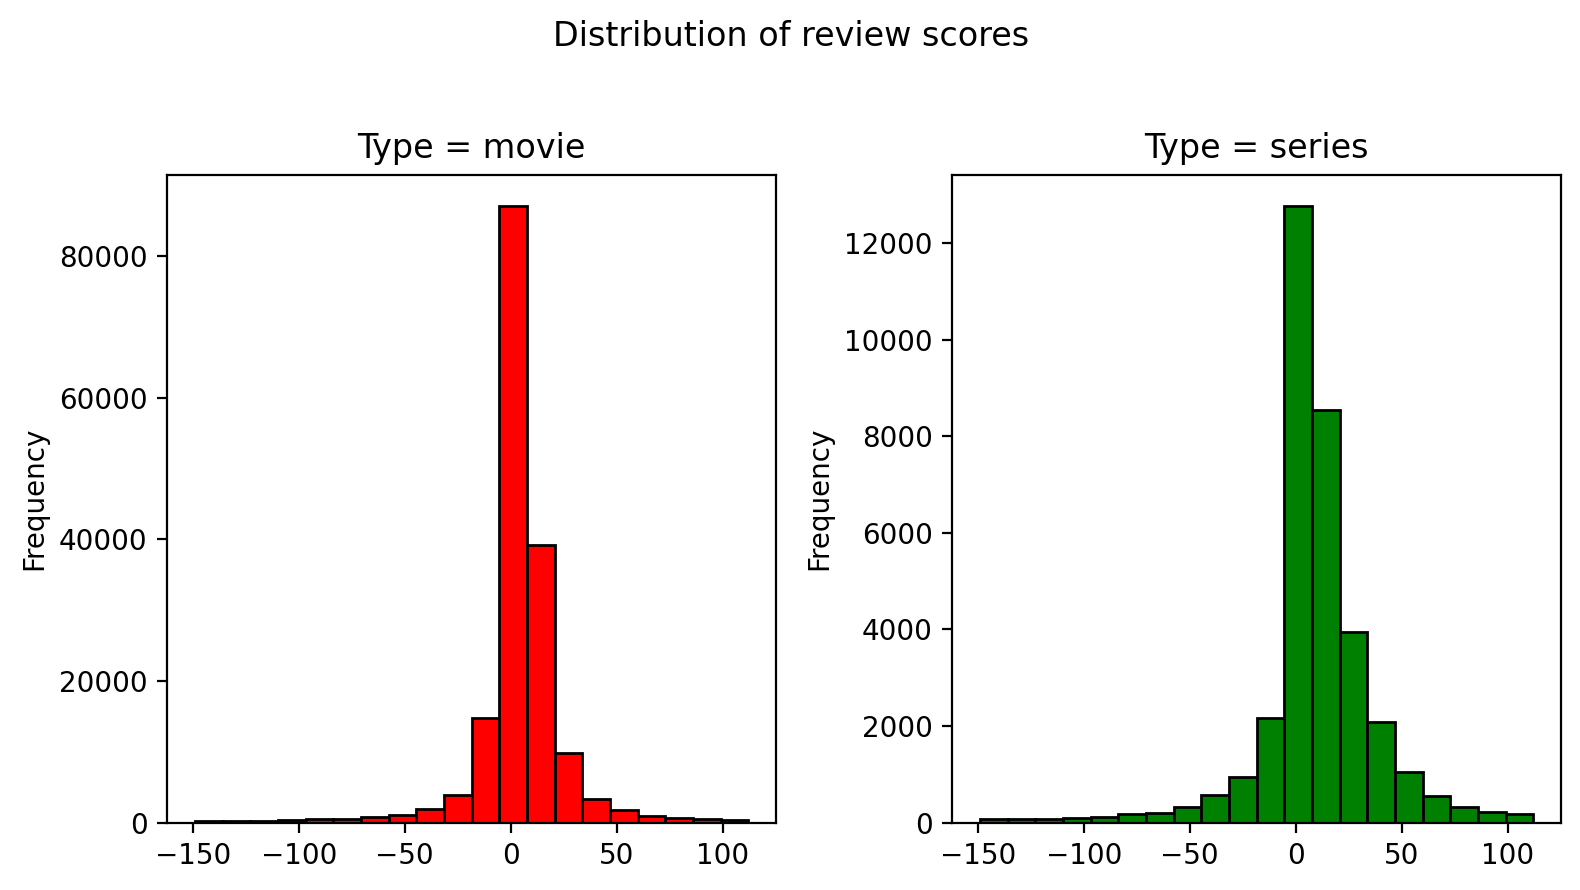

In [90]:
plot_per_type(
    dataframe=reviews[
        (reviews["review_score"] >= -149) & (reviews["review_score"] <= 112)
    ],
    column="review_score",
    title="Distribution of review scores",
    bins=20,
)

As we can see, there are a lot of reviews which are neither positively nor negatively rated by users.  
Overall, more reviews are positively rated, but some reviews are so wrong - they have a very low user's score.

### Score

Last, but not least, we have a score, which I've extracted from the reviews.  
Approximately 64% of them have such score.

In [94]:
100 - round(reviews["score"].isna().sum() * 100 / reviews.shape[0], 2)

62.56

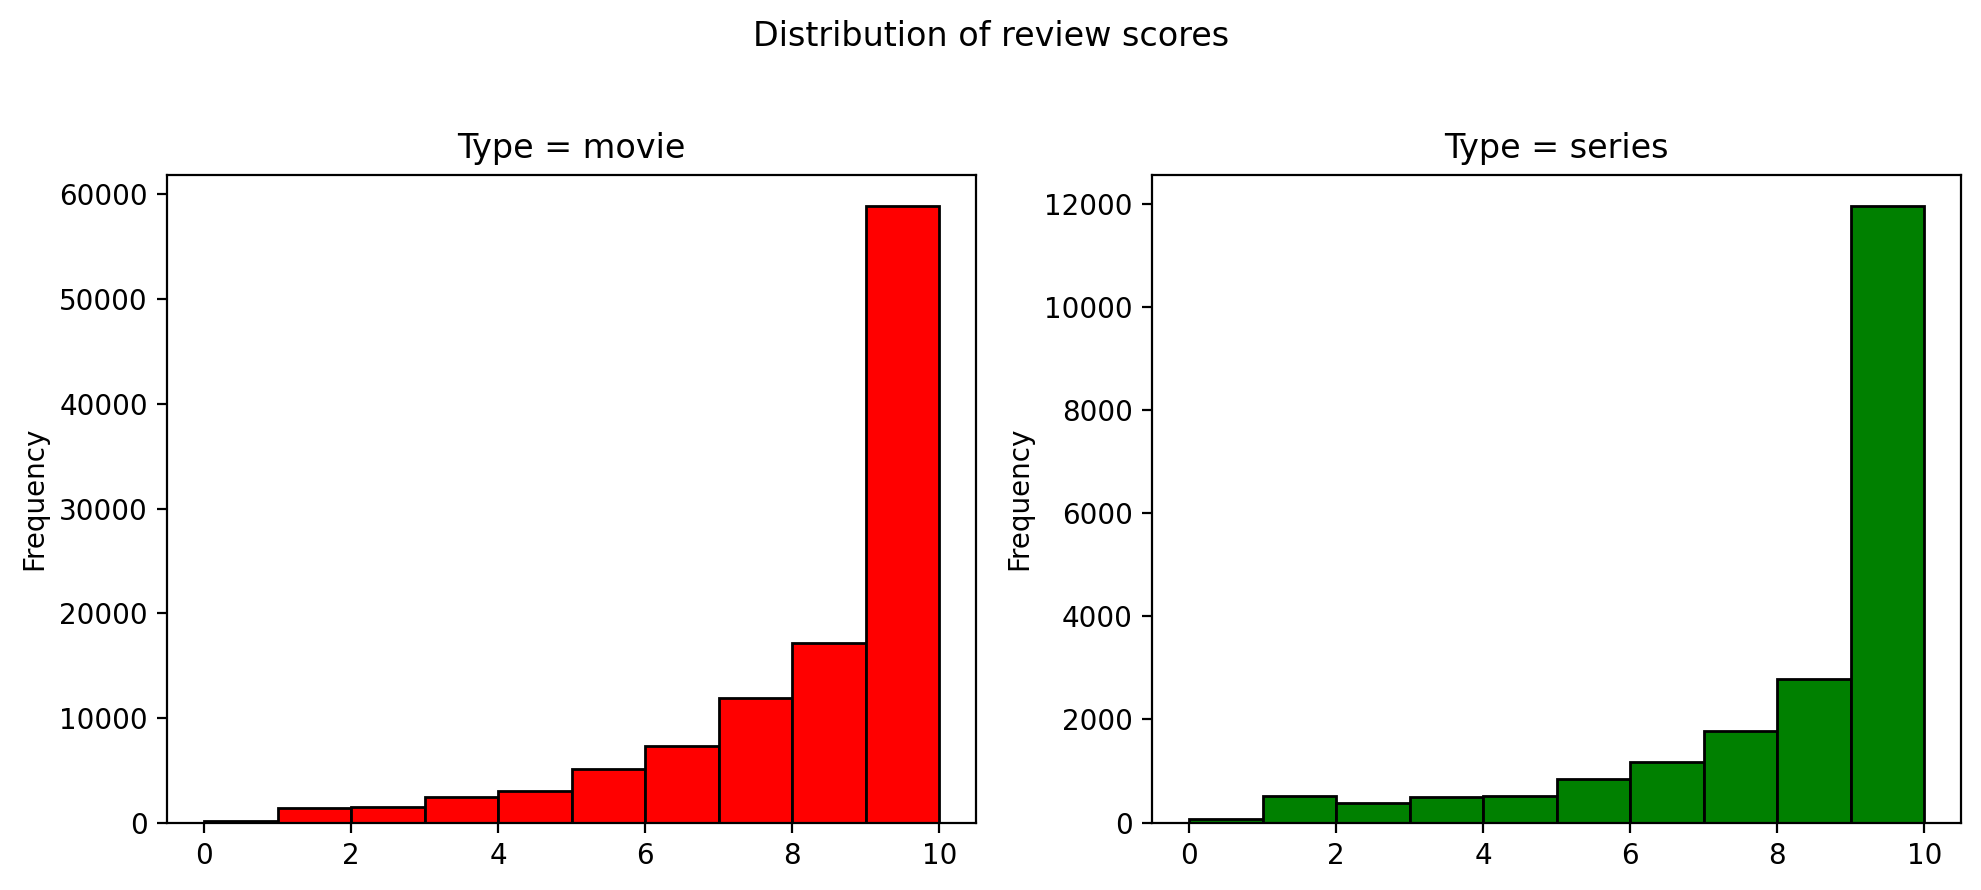

In [99]:
plot_per_type(
    dataframe=reviews,
    column="score",
    title="Distribution of review scores",
    bins=10,
    figsize=(10, 4)
)

As expected, people tend to leave high scores (me too, personally), because they either like the movie or not.

### TODO

 - Check dependency between 
   - sentiment/score and the number of tokens in review
   - sentiment and score (validation)